# 05.2 Regression Theory: Frisch-Waugh-Lovell and Partialling Out

**Chapter**: 5 - The Unreasonable Effectiveness of Linear Regression  
**Section**: 2 - Regression Theory  
**Facure Source**: 05-The-Unreasonable-Effectiveness-of-Linear-Regression.ipynb (Regression Theory section)  
**Version**: 1.0.0  
**Last Validated**: 2026-01-09

---

## Table of Contents

1. [Facure's Intuition](#1-facures-intuition)
   - 1.1 [The Best Linear Predictor](#11-the-best-linear-predictor)
   - 1.2 [The Partialling Out Interpretation](#12-the-partialling-out-interpretation)
2. [Formal Treatment](#2-formal-treatment)
   - 2.1 [Assumptions](#21-assumptions)
   - 2.2 [The Frisch-Waugh-Lovell Theorem](#22-the-frisch-waugh-lovell-theorem)
   - 2.3 [Proof of FWL](#23-proof-of-fwl)
   - 2.4 [Implications for Causal Inference](#24-implications-for-causal-inference)
3. [Numeric Demonstration](#3-numeric-demonstration)
   - 3.1 [Verifying FWL Numerically](#31-verifying-fwl-numerically)
   - 3.2 [Debiasing via Partialling Out](#32-debiasing-via-partialling-out)
4. [Implementation](#4-implementation)
   - 4.1 [The Residual Maker Matrix](#41-the-residual-maker-matrix)
   - 4.2 [Production Code](#42-production-code)
5. [Interview Appendix](#5-interview-appendix)
6. [References](#6-references)

---

In [1]:
# Standard imports via common module
import sys
sys.path.insert(0, '../..')

from facure_augment.common import (
    np, pd, plt, sm,
    load_facure_data,
    set_notebook_style,
    ols_summary_table,
    compare_coefficients,
    create_tufte_figure,
    TUFTE_PALETTE,
)

set_notebook_style()

---

## 1. Facure's Intuition

> **Interview Relevance**: The FWL theorem is a *foundational* concept that appears in technical screens at quantitative firms. Understanding partialling out is essential for explaining Double Machine Learning, control variables, and debiasing strategies.

### 1.1 The Best Linear Predictor

As Facure explains, regression solves a theoretical best linear prediction problem. Given outcome $Y$ and covariates $X$, we seek parameters $\beta^*$ that minimize mean squared error:

$$\beta^* = \underset{\beta}{\text{argmin}} \ E[(Y_i - X_i'\beta)^2]$$

The first-order condition yields the **normal equations**:

$$\beta^* = E[X_i X_i']^{-1} E[X_i Y_i]$$

The sample analogue is the familiar OLS estimator:

$$\hat{\beta} = (X'X)^{-1} X'Y$$

### 1.2 The Partialling Out Interpretation

Facure's key insight: with multiple regressors, the coefficient on treatment $T$ can be obtained via a two-step procedure:

1. Regress $T$ on all other covariates $X$, get residuals $\tilde{T}$
2. The coefficient $\kappa$ equals:

$$\kappa = \frac{\text{Cov}(Y_i, \tilde{T}_i)}{\text{Var}(\tilde{T}_i)}$$

This is profound: **the multivariate coefficient equals the bivariate coefficient after removing the linear influence of other variables**.

★ Insight ─────────────────────────────────────
- $\tilde{T}$ is "as good as random" conditional on $X$
- The residuals are orthogonal to all included covariates by construction
- This is the foundation of debiased/double machine learning
─────────────────────────────────────────────────

---

## 2. Formal Treatment

### 2.1 Assumptions

The Frisch-Waugh-Lovell theorem is a *purely algebraic* result. It requires:

**A1 (Full Column Rank)**: The design matrix $X = [X_1 \ X_2]$ has full column rank.

This ensures $(X'X)^{-1}$ exists. No distributional assumptions are needed.

### 2.2 The Frisch-Waugh-Lovell Theorem

**Theorem (Frisch-Waugh-Lovell, 1933)**[^1]

Consider the regression:
$$Y = X_1 \beta_1 + X_2 \beta_2 + \epsilon$$

where $X_1$ is $n \times k_1$ and $X_2$ is $n \times k_2$. Then:

$$\hat{\beta}_1 = (X_1' M_2 X_1)^{-1} X_1' M_2 Y$$

where $M_2 = I_n - X_2(X_2'X_2)^{-1}X_2'$ is the **residual maker** (annihilator) matrix that projects onto the space orthogonal to the columns of $X_2$.

**Equivalently**: $\hat{\beta}_1$ can be obtained by:
1. Regress $Y$ on $X_2$, get residuals $\tilde{Y} = M_2 Y$
2. Regress each column of $X_1$ on $X_2$, get residuals $\tilde{X}_1 = M_2 X_1$
3. Regress $\tilde{Y}$ on $\tilde{X}_1$: the coefficient is $\hat{\beta}_1$

### 2.3 Proof of FWL

**Proof**: We provide two approaches—the direct algebraic proof and the geometric interpretation.

**Part I: Algebraic Proof**

Starting from the partitioned normal equations. With $X = [X_1 \ X_2]$ and $\beta = [\beta_1' \ \beta_2']'$:

$$
\begin{bmatrix} X_1'X_1 & X_1'X_2 \\ X_2'X_1 & X_2'X_2 \end{bmatrix}
\begin{bmatrix} \hat{\beta}_1 \\ \hat{\beta}_2 \end{bmatrix}
= \begin{bmatrix} X_1'Y \\ X_2'Y \end{bmatrix}
$$

From the second block equation:
$$X_2'X_1 \hat{\beta}_1 + X_2'X_2 \hat{\beta}_2 = X_2'Y$$
$$\hat{\beta}_2 = (X_2'X_2)^{-1}(X_2'Y - X_2'X_1 \hat{\beta}_1)$$

Substituting into the first block equation:
$$X_1'X_1 \hat{\beta}_1 + X_1'X_2 (X_2'X_2)^{-1}(X_2'Y - X_2'X_1 \hat{\beta}_1) = X_1'Y$$

Rearranging (letting $P_2 = X_2(X_2'X_2)^{-1}X_2'$):
$$X_1'X_1 \hat{\beta}_1 - X_1'P_2 X_1 \hat{\beta}_1 = X_1'Y - X_1'P_2 Y$$
$$X_1'(I - P_2)X_1 \hat{\beta}_1 = X_1'(I - P_2)Y$$
$$X_1' M_2 X_1 \hat{\beta}_1 = X_1' M_2 Y$$

Therefore:
$$\boxed{\hat{\beta}_1 = (X_1' M_2 X_1)^{-1} X_1' M_2 Y}$$

Since $M_2$ is symmetric and idempotent ($M_2 = M_2' = M_2^2$):
$$\hat{\beta}_1 = ((M_2 X_1)' M_2 X_1)^{-1} (M_2 X_1)' M_2 Y = (\tilde{X}_1' \tilde{X}_1)^{-1} \tilde{X}_1' \tilde{Y}$$

This is exactly OLS of $\tilde{Y}$ on $\tilde{X}_1$. $\blacksquare$

**Part II: Geometric Interpretation**

Let $\mathcal{C}(X_2)$ denote the column space of $X_2$.

- $P_2 = X_2(X_2'X_2)^{-1}X_2'$ projects onto $\mathcal{C}(X_2)$
- $M_2 = I - P_2$ projects onto $\mathcal{C}(X_2)^\perp$

The FWL theorem says: to find $\hat{\beta}_1$, we can work entirely in the orthogonal complement of $\mathcal{C}(X_2)$. This removes the "influence" of $X_2$ from both $Y$ and $X_1$.

### 2.4 Implications for Causal Inference

**Proposition (Conditional Exogeneity)**: If treatment $T$ satisfies $(Y_0, Y_1) \perp T | X$, then partialling out $X$ from $T$ creates variation that is "as good as random":

$$\tilde{T} = T - E[T|X]$$

is uncorrelated with any function of $X$, by construction.

This is the foundation of:
1. **Control variable adjustment**: Adding confounders to remove omitted variable bias
2. **Double Machine Learning**: Using flexible ML to estimate $E[T|X]$ and $E[Y|X]$
3. **Neyman orthogonality**: The influence function becomes insensitive to first-stage estimation error

---

## 3. Numeric Demonstration

### 3.1 Verifying FWL Numerically

We replicate Facure's wage example and verify FWL to machine precision.

In [2]:
# Load Facure's wage data
wage = load_facure_data('wage.csv').dropna()
wage['lhwage'] = np.log(wage['wage'] / wage['hours'])

# Define variables
controls = ['IQ', 'exper', 'tenure', 'age', 'married', 'black',
            'south', 'urban', 'sibs', 'brthord', 'meduc', 'feduc']

y = wage['lhwage'].values
T = wage['educ'].values
X = wage[controls].values

# Add constant to controls
X_const = sm.add_constant(X)

print(f"Sample size: n = {len(y)}")
print(f"Treatment: education (years)")
print(f"Outcome: log hourly wage")
print(f"Controls: {len(controls)} variables")

Sample size: n = 663
Treatment: education (years)
Outcome: log hourly wage
Controls: 12 variables


In [3]:
# Method 1: Full multivariate regression
X_full = np.column_stack([T, X_const])
beta_full = np.linalg.lstsq(X_full, y, rcond=None)[0]
kappa_full = beta_full[0]

print("Method 1: Full Regression")
print(f"  β_educ = {kappa_full:.10f}")

Method 1: Full Regression
  β_educ = 0.0411471910


In [4]:
# Method 2: FWL - Partialling out via residuals
# Step 1: Residualize T on X
beta_T = np.linalg.lstsq(X_const, T, rcond=None)[0]
T_tilde = T - X_const @ beta_T

# Step 2: Residualize Y on X
beta_Y = np.linalg.lstsq(X_const, y, rcond=None)[0]
Y_tilde = y - X_const @ beta_Y

# Step 3: Bivariate regression of Y_tilde on T_tilde
kappa_fwl = np.cov(Y_tilde, T_tilde)[0, 1] / np.var(T_tilde, ddof=1)

print("Method 2: FWL (Partialling Out)")
print(f"  β_educ = {kappa_fwl:.10f}")

Method 2: FWL (Partialling Out)
  β_educ = 0.0411471910


In [5]:
# Method 3: FWL using residual maker matrix directly
n = len(y)
P_X = X_const @ np.linalg.inv(X_const.T @ X_const) @ X_const.T
M_X = np.eye(n) - P_X

# Apply FWL formula
T_mat = T.reshape(-1, 1)
kappa_matrix = np.linalg.inv(T_mat.T @ M_X @ T_mat) @ (T_mat.T @ M_X @ y)
kappa_matrix = kappa_matrix[0]

print("Method 3: Residual Maker Matrix")
print(f"  β_educ = {kappa_matrix:.10f}")

Method 3: Residual Maker Matrix
  β_educ = 0.0411471910


In [6]:
# Verify all methods match to machine precision
print("\n" + "="*50)
print("VERIFICATION: All methods match?")
print("="*50)

tol = 1e-10
match_1_2 = np.isclose(kappa_full, kappa_fwl, rtol=tol)
match_1_3 = np.isclose(kappa_full, kappa_matrix, rtol=tol)

print(f"Full vs FWL:    |Δ| = {abs(kappa_full - kappa_fwl):.2e} → {'✓ MATCH' if match_1_2 else '✗ FAIL'}")
print(f"Full vs Matrix: |Δ| = {abs(kappa_full - kappa_matrix):.2e} → {'✓ MATCH' if match_1_3 else '✗ FAIL'}")

assert match_1_2 and match_1_3, "FWL verification failed!"


VERIFICATION: All methods match?
Full vs FWL:    |Δ| = 1.34e-15 → ✓ MATCH
Full vs Matrix: |Δ| = 1.74e-13 → ✓ MATCH


### 3.2 Debiasing via Partialling Out

Demonstrate how partialling out removes confounding.

In [7]:
# Bivariate regression (omitting controls) - BIASED
T_const = sm.add_constant(T)
beta_biased = np.linalg.lstsq(T_const, y, rcond=None)[0]
kappa_biased = beta_biased[1]

print("Omitted Variable Bias Demonstration")
print("="*50)
print(f"Biased estimate (no controls):  {kappa_biased:.4f}")
print(f"Debiased estimate (FWL):        {kappa_fwl:.4f}")
print(f"")
print(f"Bias = {kappa_biased - kappa_fwl:.4f}")
print(f"Bias direction: {'Positive (overestimate)' if kappa_biased > kappa_fwl else 'Negative'}")

Omitted Variable Bias Demonstration
Biased estimate (no controls):  0.0536
Debiased estimate (FWL):        0.0411

Bias = 0.0125
Bias direction: Positive (overestimate)


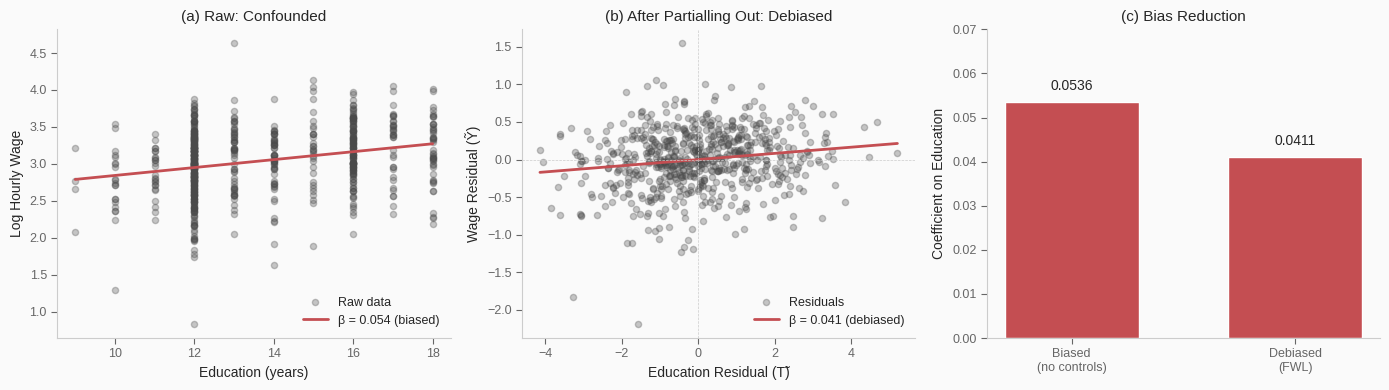

In [8]:
# Visualize the partialling out process
fig, axes = create_tufte_figure(1, 3, figsize=(14, 4))

# Panel 1: Raw relationship (confounded)
ax = axes[0]
ax.scatter(T, y, alpha=0.3, s=20, c=TUFTE_PALETTE['primary'], label='Raw data')
T_grid = np.linspace(T.min(), T.max(), 100)
ax.plot(T_grid, beta_biased[0] + beta_biased[1] * T_grid, 
        c=TUFTE_PALETTE['bias'], lw=2, label=f'β = {kappa_biased:.3f} (biased)')
ax.set_xlabel('Education (years)')
ax.set_ylabel('Log Hourly Wage')
ax.set_title('(a) Raw: Confounded')
ax.legend(loc='lower right', frameon=False)

# Panel 2: Residualized relationship
ax = axes[1]
ax.scatter(T_tilde, Y_tilde, alpha=0.3, s=20, c=TUFTE_PALETTE['primary'], label='Residuals')
T_tilde_grid = np.linspace(T_tilde.min(), T_tilde.max(), 100)
ax.plot(T_tilde_grid, kappa_fwl * T_tilde_grid, 
        c=TUFTE_PALETTE['effect'], lw=2, label=f'β = {kappa_fwl:.3f} (debiased)')
ax.axhline(0, c=TUFTE_PALETTE['spine'], ls='--', lw=0.5)
ax.axvline(0, c=TUFTE_PALETTE['spine'], ls='--', lw=0.5)
ax.set_xlabel('Education Residual (T̃)')
ax.set_ylabel('Wage Residual (Ỹ)')
ax.set_title('(b) After Partialling Out: Debiased')
ax.legend(loc='lower right', frameon=False)

# Panel 3: Coefficient comparison
ax = axes[2]
methods = ['Biased\n(no controls)', 'Debiased\n(FWL)']
coefs = [kappa_biased, kappa_fwl]
colors = [TUFTE_PALETTE['bias'], TUFTE_PALETTE['effect']]
bars = ax.bar(methods, coefs, color=colors, width=0.6, edgecolor='white')
ax.axhline(0, c=TUFTE_PALETTE['spine'], lw=0.5)

# Direct labels
for bar, coef in zip(bars, coefs):
    ax.text(bar.get_x() + bar.get_width()/2, coef + 0.002, 
            f'{coef:.4f}', ha='center', va='bottom', fontsize=10)

ax.set_ylabel('Coefficient on Education')
ax.set_title('(c) Bias Reduction')
ax.set_ylim(0, 0.07)

plt.tight_layout()
plt.show()

---

## 4. Implementation

### 4.1 The Residual Maker Matrix

The residual maker (annihilator) matrix is fundamental to understanding regression.

In [9]:
def residual_maker(X: np.ndarray) -> np.ndarray:
    """
    Compute the residual maker (annihilator) matrix M = I - P.
    
    Parameters
    ----------
    X : np.ndarray
        Design matrix (n x k).
        
    Returns
    -------
    M : np.ndarray
        Residual maker matrix (n x n) that projects onto C(X)^⊥.
        
    Properties
    ----------
    - Symmetric: M = M'
    - Idempotent: M² = M
    - MX = 0 (annihilates columns of X)
    - trace(M) = n - k
    
    Examples
    --------
    >>> X = np.array([[1, 2], [1, 3], [1, 5]])
    >>> M = residual_maker(X)
    >>> np.allclose(M @ X, 0)  # Annihilates X
    True
    """
    n = X.shape[0]
    P = X @ np.linalg.inv(X.T @ X) @ X.T
    M = np.eye(n) - P
    return M


def fwl_coefficient(y: np.ndarray, T: np.ndarray, X: np.ndarray) -> float:
    """
    Compute treatment coefficient via Frisch-Waugh-Lovell.
    
    Parameters
    ----------
    y : np.ndarray
        Outcome vector (n,).
    T : np.ndarray
        Treatment vector (n,).
    X : np.ndarray
        Control matrix (n x k), should include constant.
        
    Returns
    -------
    kappa : float
        Treatment coefficient after partialling out X.
        
    Notes
    -----
    Implements: κ = (T'M_X T)^{-1} T'M_X y
    where M_X = I - X(X'X)^{-1}X'
    """
    M = residual_maker(X)
    T_tilde = M @ T
    Y_tilde = M @ y
    
    # Bivariate formula on residuals
    kappa = (T_tilde @ Y_tilde) / (T_tilde @ T_tilde)
    return kappa

In [10]:
# Verify properties of residual maker
M = residual_maker(X_const)

print("Residual Maker Properties")
print("="*50)
print(f"Symmetric (M = M'): {np.allclose(M, M.T)}")
print(f"Idempotent (M² = M): {np.allclose(M @ M, M)}")
print(f"Annihilates X (MX ≈ 0): {np.allclose(M @ X_const, 0)}")
print(f"trace(M) = n - k: {np.trace(M):.1f} vs {n - X_const.shape[1]:.1f}")

Residual Maker Properties
Symmetric (M = M'): True
Idempotent (M² = M): True
Annihilates X (MX ≈ 0): True
trace(M) = n - k: 650.0 vs 650.0


### 4.2 Production Code

Reference implementation from `causal_inference_mastery`:

In [11]:
# Link to production DML implementation
# from causal_inference.cate.dml import DoubleMachineLearning

# The DML estimator uses FWL/partialling out as its foundation:
# 1. Estimate E[Y|X] with ML model → get Y residuals
# 2. Estimate E[T|X] with ML model → get T residuals  
# 3. Regress Y residuals on T residuals → get θ

# This is exactly FWL with flexible first-stage estimation!

---

## 5. Interview Appendix

### Practice Questions

**Q1 (Google L5, DS)**: *"Explain the Frisch-Waugh-Lovell theorem and why it matters for causal inference."*

<details>
<summary>Solution</summary>

**Key points to hit:**

1. **Statement**: In regression $Y = X_1\beta_1 + X_2\beta_2 + \epsilon$, the coefficient $\hat{\beta}_1$ equals the coefficient from regressing the residuals of $Y$ on $X_2$ against the residuals of $X_1$ on $X_2$.

2. **Intuition**: "Partialling out" removes the linear influence of controls. What remains in $\tilde{T} = T - E[T|X]$ is variation that cannot be predicted by $X$.

3. **Causal relevance**: 
   - If confounders $X$ satisfy conditional ignorability, then $\tilde{T}$ is "as good as random"
   - The coefficient captures causal effect after adjustment
   - Foundation for Double Machine Learning: use ML to flexibly estimate $E[T|X]$ and $E[Y|X]$

4. **Mathematical insight**: The residual maker $M = I - X(X'X)^{-1}X'$ projects onto the orthogonal complement of $\mathcal{C}(X)$. FWL says we can work entirely in this subspace.

**Common follow-up**: "What happens if we omit a confounder?"
→ Omitted variable bias formula: $\hat{\beta}_{short} = \beta_{long} + \gamma \delta$, where $\gamma$ is effect of omitted on outcome, $\delta$ is regression of omitted on included.

</details>

---

**Q2 (Meta IC5, Economist)**: *"A colleague says 'just throw all variables into the regression to control for confounding.' What's wrong with this advice?"*

<details>
<summary>Solution</summary>

**Problems with "kitchen sink" regression:**

1. **Bad controls**: Including post-treatment variables (mediators, colliders) can *introduce* bias
   - Collider bias: conditioning on a common effect opens a backdoor path
   - Mediator bias: partialling out the mechanism removes part of the effect

2. **Multicollinearity**: Adding highly correlated variables inflates standard errors without reducing bias

3. **Overfitting in finite samples**: More controls means more parameters, potentially worse MSE

4. **Not all confounders are observed**: Even with "all" measured variables, unobserved confounders may remain

**Better approach:**
- Draw a DAG to identify which variables are confounders vs. bad controls
- Use the backdoor criterion: condition on variables that block all backdoor paths
- Only include pre-treatment confounders

</details>

---

**Q3 (Two Sigma, Quant)**: *"Derive the omitted variable bias formula."*

<details>
<summary>Solution</summary>

**Setup**: True model is $Y = T\kappa + A\gamma + \epsilon$, but we estimate $Y = T\hat{\kappa}_{short} + e$.

**Derivation**:

The short regression coefficient:
$$\hat{\kappa}_{short} = \frac{\text{Cov}(Y, T)}{\text{Var}(T)}$$

Substitute $Y = T\kappa + A\gamma + \epsilon$:
$$= \frac{\text{Cov}(T\kappa + A\gamma + \epsilon, T)}{\text{Var}(T)}$$
$$= \kappa + \gamma \cdot \frac{\text{Cov}(A, T)}{\text{Var}(T)}$$
$$= \kappa + \gamma \cdot \delta$$

where $\delta = \frac{\text{Cov}(A,T)}{\text{Var}(T)}$ is the coefficient from regressing $A$ on $T$.

**Bias** = $\gamma \delta$ = (effect of omitted on Y) × (regression of omitted on included)

**When is bias zero?**
- $\gamma = 0$: omitted doesn't affect outcome (not a confounder)
- $\delta = 0$: omitted uncorrelated with treatment (randomization!)

</details>

---

## 6. References

[^1]: Frisch, R. and Waugh, F. V. (1933). Partial Time Regressions as Compared with Individual Trends. *Econometrica*, 1(4), 387-401.

[^2]: Lovell, M. C. (1963). Seasonal Adjustment of Economic Time Series and Multiple Regression Analysis. *Journal of the American Statistical Association*, 58(304), 993-1010.

[^3]: Angrist, J. D. and Pischke, J.-S. (2009). *Mostly Harmless Econometrics*. Princeton University Press, Chapter 3.

[^4]: Chernozhukov, V. et al. (2018). Double/Debiased Machine Learning for Treatment and Structural Parameters. *The Econometrics Journal*, 21(1), C1-C68. [research_kb: `2bc757a2-8fc9-4622-a733-a18814df7a0b`]

[^5]: Facure, M. (2023). *Causal Inference for the Brave and True*. Chapter 5.

---

**Precision Improvement:**
- You said: "Make a notebook about regression theory"
- Concise: "Build FWL notebook with proof and numerics"
- Precise: `/augmented 05.2 regression_theory --fwl-proof --numeric-demo`
- Pattern: [build] [target] [content-flags]